**Column description:**

footfall: The number of people or objects passing by the machine.

tempMode: The temperature mode or setting of the machine.

AQ: Air quality index near the machine.

USS: Ultrasonic sensor data, indicating proximity measurements.

CS: Current sensor readings, indicating the electrical current usage of the machine.

VOC: Volatile organic compounds level detected near the machine.

RP: Rotational position or RPM (revolutions per minute) of the machine parts.

IP: Input pressure to the machine.

Temperature: The operating temperature of the machine.

fail: Binary indicator of machine failure (1 for failure, 0 for no failure).

# import libraries & datasets

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy.stats import chi2_contingency
from imblearn.combine import SMOTETomek
import streamlit as st
import plotly.express as px
from statsmodels.stats.proportion import proportion_confint
import joblib
import warnings
warnings.filterwarnings('ignore')

In [31]:
df = pd.read_csv('data.csv')

In [32]:
df.head()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0


In [33]:
df.shape

(944, 10)

In [34]:
df.fail.value_counts()

0    551
1    393
Name: fail, dtype: int64

imbalanced class, hence will do oversampling

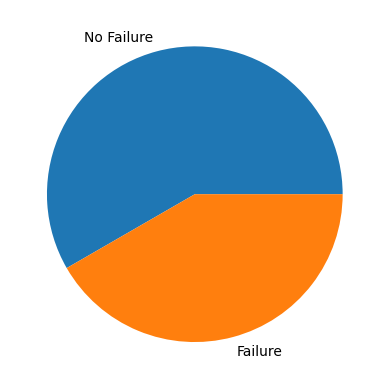

In [74]:
plt.pie(df['fail'].value_counts(), labels=['No Failure','Failure'])
plt.show()

# data preprocessing 

In [35]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
footfall,944.0,306.381356,1082.606745,0.0,1.0,22.0,110.0,7300.0
tempMode,944.0,3.727754,2.677235,0.0,1.0,3.0,7.0,7.0
AQ,944.0,4.325212,1.438436,1.0,3.0,4.0,6.0,7.0
USS,944.0,2.939619,1.383725,1.0,2.0,3.0,4.0,7.0
CS,944.0,5.394068,1.269349,1.0,5.0,6.0,6.0,7.0
VOC,944.0,2.842161,2.273337,0.0,1.0,2.0,5.0,6.0
RP,944.0,47.043432,16.423130,19.0,34.0,44.0,58.0,91.0
IP,944.0,4.565678,1.599287,1.0,3.0,4.0,6.0,7.0
Temperature,944.0,16.331568,5.974781,1.0,14.0,17.0,21.0,24.0
fail,944.0,0.416314,0.493208,0.0,0.0,0.0,1.0,1.0


In [36]:
# removing duplicates
df.drop_duplicates(inplace=True)

# converting cols to lowercase
df.columns = df.columns.str.lower()

# predictive modeling using XGBoost

In [ ]:
features = ['footfall', 'tempmode', 'aq', 'uss', 'cs']
X = df[features]
y = df['fail']

# normalizing features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# oversampling 
smote = SMOTETomek(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# splitting data 
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# training xgboost model
xgb = XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.3, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [56]:
cv_scores = cross_val_score(xgb, X_res, y_res, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std() * 2:.4f}")

Cross-Validation Accuracy: 0.8886 ± 0.0445


In [53]:
# evaluation
print('Classification Report:\n\n',classification_report(y_test, y_pred))

print('Confusion Matrix:\n\n',confusion_matrix(y_test,y_pred))

print('\nAccuracy:',accuracy_score(y_test,y_pred))

Classification Report:

               precision    recall  f1-score   support

           0       0.93      0.91      0.92       108
           1       0.90      0.93      0.92        99

    accuracy                           0.92       207
   macro avg       0.92      0.92      0.92       207
weighted avg       0.92      0.92      0.92       207

Confusion Matrix:

 [[98 10]
 [ 7 92]]

Accuracy: 0.9178743961352657


#### Goal is to predict failures for maintenance in advance, and while timestamps are absent, A/B testing can simulate maintenance strategies using failure probabilities. 

In [41]:
# A/B testing
# predicting probabilities
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# Define thresholds: 0.7 for urgent maintenance, 0.5 for monitoring 
thresholds = [0.5, 0.7, 0.9]
for thresh in thresholds:
    y_pred = (y_pred_proba > thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    missed_failures = cm[1, 0]  # False negatives
    unnecessary_maintenance = cm[0, 1]  # False positives
    print(f"Threshold {thresh}: Missed Failures = {missed_failures}, Unnecessary Maintenance = {unnecessary_maintenance}")

Threshold 0.5: Missed Failures = 7, Unnecessary Maintenance = 10
Threshold 0.7: Missed Failures = 9, Unnecessary Maintenance = 8
Threshold 0.9: Missed Failures = 17, Unnecessary Maintenance = 5


* Threshold 0.5 - MONITORING
* Threshold 0.7 - URGENT MAINTENANCE
* Threshold >0.7 - REPLACEMENT REQUIRED

#### Statistical validation
Confidence intervals for model accuracy assess how reliable our failure predictions are, ensuring trust in maintenance decisions for machines. eg, A 95% CI means there’s a 95% chance the true accuracy lies within the interval.

In [75]:
# confidence intervals
y_pred = xgb.predict(X_test)
correct = np.sum(y_test == y_pred)
n = len(y_test)
accuracy = correct / n
ci_low, ci_high = proportion_confint(correct, n, alpha=0.05, method='wilson')
print(f"Accuracy: {accuracy:.4f}, 95% CI: ({ci_low:.4f}, {ci_high:.4f})")

Accuracy: 0.9179, 95% CI: (0.8724, 0.9481)


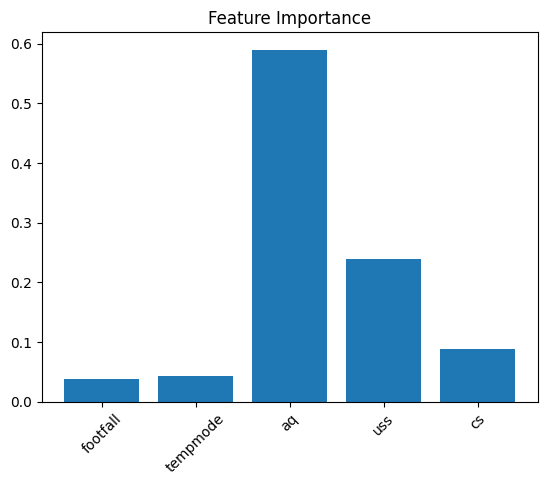

In [48]:
importances = xgb.feature_importances_
plt.bar(features, importances)
plt.xticks(rotation=45)
plt.title("Feature Importance")
plt.show()

## 📌 Air Quality Index (AQ) is the most important feature followed by Ultrasonic Sensor (USS) and Current Sensor (CS)

# Save the model

In [57]:
joblib.dump(xgb, 'xgb_model_static.pkl')

['xgb_model_static.pkl']

# LSTM

In [128]:
df.head()

,footfall,tempmode,aq,uss,cs,voc,rp,ip,temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0


In [141]:
features = ['footfall', 'tempmode', 'aq', 'uss', 'cs']
X = df[features].values
y= df['fail'].values

# normalizing features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# oversampling 
smote = SMOTETomek(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# Create sequences (e.g., 5 time steps)
def create_sequences(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 5
X_seq, y_seq = create_sequences(X_res, y_res)

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# buliding and training LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, len(features))))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
y_pred = (model.predict(X_test) > 0.5).astype(int)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5651 - loss: 0.6855 - val_accuracy: 0.4909 - val_loss: 0.6900
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5775 - loss: 0.6762 - val_accuracy: 0.5333 - val_loss: 0.6847
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6496 - loss: 0.6650 - val_accuracy: 0.4909 - val_loss: 0.6880
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6206 - loss: 0.6482 - val_accuracy: 0.5636 - val_loss: 0.6852
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6775 - loss: 0.6172 - val_accuracy: 0.5455 - val_loss: 0.7045
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6124 - loss: 0.6295 - val_accuracy: 0.5697 - val_loss: 0.7019
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6114 - loss: 0.6504 - val_accuracy: 0.5455 - val_loss: 0.6962
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6617 - loss: 0.6158 - val_accuracy: 0.5515 - val_loss:

In [142]:
# Evaluate
print('Classification Report:\n\n',classification_report(y_test, y_pred))

print('Confusion Matrix:\n\n',confusion_matrix(y_test,y_pred))

print('\nAccuracy:',accuracy_score(y_test,y_pred))

Classification Report:

               precision    recall  f1-score   support

           0       0.70      0.61      0.65       114
           1       0.58      0.67      0.62        92

    accuracy                           0.64       206
   macro avg       0.64      0.64      0.64       206
weighted avg       0.64      0.64      0.64       206

Confusion Matrix:

 [[69 45]
 [30 62]]

Accuracy: 0.6359223300970874


# ‼️ LSTM underperformed XGBoost due to some limitations, like lack of timestamps in the data